# Map geospatial data to census zones 
Author: Koki Sasagawa
Last edited: 3/20/2019

Should work with any datapoints that have lon lat coordinates

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import urllib
import json 
import re
import os
import sys
from shapely.geometry import Point

sys.path.insert(0, '../utils/')
from decorators import timer, repeater

%matplotlib inline

In [18]:
# Specifiy directory containing shape file
gis_data_dir = '../../temp_data/'

In [19]:
files = os.listdir(gis_data_dir)
for i, n in enumerate(files):
    print(i,n)

0 .DS_Store
1 test.csv
2 sfdata_mapped
3 dummy_df.csv
4 sf_filtered_census_data.shx
5 sf_filtered_census_data.shp
6 sf_filtered_census_data.cpg
7 test1.csv
8 region_data
9 sf_filtered_census_data.dbf
10 sfdata_clean


# 1. SF 2010 census tracts data
[dataset link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Census-2010-Tracts-for-San-Francisco/rarb-5ahf)

`shp` - file containing geometry of each feature  
`dbf` - dBase file containing attribute data for all of the features in the dataset  
`shx` - spatial index, allows GIS systems to find features within the shp files  
`prj` - projection file containing information about the projection and coordinate system the data uses


| Code        | Description |
|:------------|:------------|
| aland10     | Area(land)  |
| awater10    | Area(Water) |
| countryfp10 | County FIPS |
| funcstat10  | Functional Status Code (e.g., S = Statistical Entity) |
| geoid10     | Numeric codes that uniquely identify all administrative/legal and statistical geographic areas |
| intptlat10  | Internal Point (Latitude) |
| intptlon10  | Internal Point (Longitude) |
| mtfcc10     | MAF/TiGER feature class code |
| namelsad    | Current name and the translated lega/statistical area dscription |
| statefp10   | state FIPS |
| tractce10   | census tract |
| geometry    | shape on earth as specified by lat and lon |

`FIPS`- Federal Information Processing Series: numeric codes assigned by the National Institude of Standards and Technology (NIST). Deals with US states and counties. US states identified with a 2-digit number while US counties are idnentified by a 3-digit number. 
> Example:
> FIPS code: 06071 represents
> California - 06
> San Bernardino County - 071

In [20]:
sf_census_zones = gpd.GeoDataFrame.from_file(gis_data_dir + files[5])
print('Size of census zones df: {}'.format(sf_census_zones.shape))
sf_census_zones.head()

Size of census zones df: (196, 13)


,aland10,awater10,countyfp10,funcstat10,geoid10,intptlat10,intptlon10,mtfcc10,name10,namelsad10,statefp10,tractce10,geometry
0,370459.0,0.0,075,S,6075016500,37.774196,-122.447788,G5020,165,Census Tract 165,06,016500,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,309097.0,0.0,075,S,6075016400,37.775100,-122.436973,G5020,164,Census Tract 164,06,016400,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,245867.0,0.0,075,S,6075016300,37.776046,-122.429551,G5020,163,Census Tract 163,06,016300,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,368901.0,0.0,075,S,6075016100,37.779983,-122.428663,G5020,161,Census Tract 161,06,016100,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,158236.0,0.0,075,S,6075016000,37.782336,-122.422484,G5020,160,Census Tract 160,06,016000,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


There are many columns we do not need. To remove them and save space, generate a new shape file and store in the temp_data folder

In [22]:
sf_census_zones.dtypes

aland10       float64
awater10      float64
countyfp10     object
funcstat10     object
geoid10         int64
intptlat10    float64
intptlon10    float64
mtfcc10        object
name10         object
namelsad10     object
statefp10      object
tractce10      object
geometry       object
dtype: object

In [23]:
sf_census_zones.crs

{}

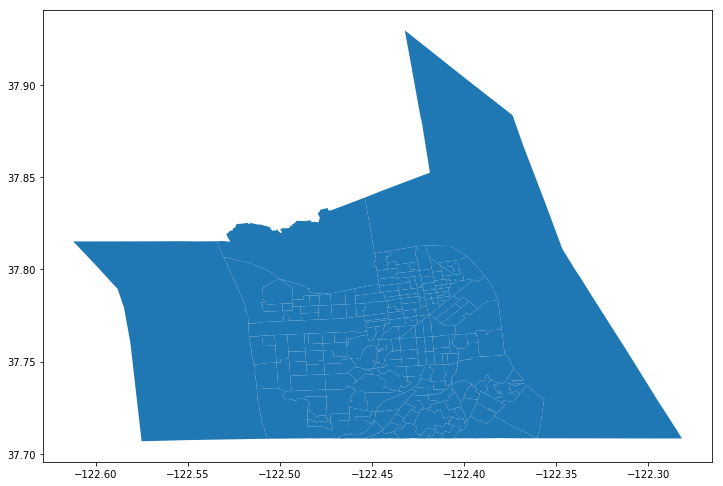

In [25]:
sf_census_zones.plot(figsize=(12, 12))

## Save unqiue ID and GIS polygon of census zones

In [26]:
relevant_col = sf_census_zones.columns[[4, 12]].to_list()

In [28]:
# Save new census file in temp folder
sf_census_zones[relevant_col].to_file('../../temp_data/sf_GEOID_GIS_data.shp')

# 2. Uber census tract data

*Important Note:* We will not be using the uber data for this project as the census zones are actually not limited to SF, but the broader area of northern california

In [30]:
raw_data = '../../raw_data/census_zones/sf/'

data = gpd.read_file(raw_data + 'san_francisco_censustracts.json')
print(data.shape)
data.head()

(2710, 3)


,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","(POLYGON ((-121.595108 36.111261, -121.540189 ..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","(POLYGON ((-122.224626 37.465065, -122.223616 ..."
2,3,"18300 Sutter Boulevard, Morgan Hill","(POLYGON ((-121.679781 37.158594, -121.671983 ..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","(POLYGON ((-121.359211 38.57175, -121.346287 3..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","(POLYGON ((-121.375124 38.553093, -121.371535 ..."


In [31]:
data.dtypes

MOVEMENT_ID     object
DISPLAY_NAME    object
geometry        object
dtype: object

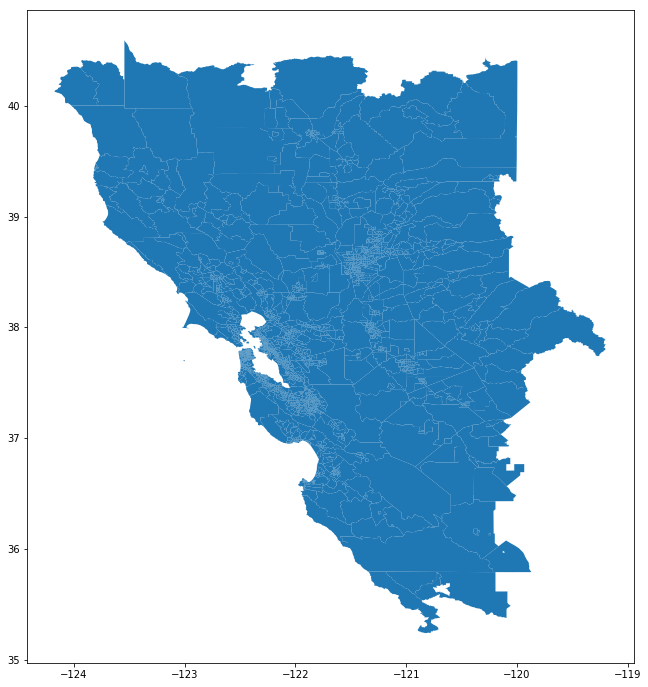

In [32]:
data.plot(figsize=(12, 12))

Not really just sf census data, but spans over the central, norther california. 

# 3. DataSF Historical raw AVL/GPS data 
Each file contains 24 hours of data from the GPS units afficed to SFMTA vehicles.

The raw files contain formatting mistakes on the first row which combines it to the header row when reading as a csv. Creating a regular expression formatter to fix this for all files

In [13]:
input_dir = '../raw_data/sf_speed_data/'
output_dir = '../temp_data/sfdata_clean/'

# Check that file exists
file_name = os.listdir(input_dir)[0]
print(file_name)

sfmtaAVLRawData01312016.csv


In [14]:
# def file_cleaner(data_input, data_output, file_name):
#     '''Reads in SF speed data and formats them into proper csv files'''
    
#     with open(data_intput + file_name, 'r') as old_file:
#         with open(data_output + file_name, 'w') as new_file:
#             first = 0 
#             for line in old_file.readlines():
#                 # If it is the first line, separate the header from the data
#                 if first == 0: 
#                     line = re.sub(r'\t|\n|\s+', '', line)
#                     header = re.findall(r'[A-Z+?\_?]+', line)
#                     data = re.findall(r'[\-?\d+?\/?\.?\:?]+|\,(?=\,)', line)
                    
#                     # Date and time are connected 
#                     date = re.search(r'(\d{2}\/){2}\d{4}', data[1]).group(0)
#                     time = re.search(r'(\d{2}\:){2}\d{2}', data[1]).group(0)
#                     date = date + ' ' + time 
                    
#                     # Remove the merged date and time
#                     data.remove(data[1])
                    
#                     # Insert separated date and time
#                     data.insert(1, date)
                    
#                     data = [x if x != ',' else '' for x in data]
#                     header = (',').join(header)
#                     data = (',').join(data)
#                     new_file.write(header + '\n')
#                     new_file.write(data + '\n')
#                     first += 1 
#                 else:
#                     if line != '\n':
#                         line = line.rstrip()
#                         new_file.write(line + '\n')

In [15]:
# file_cleaner(input_dir, data_output, file_name)

## Read data with datetime field

Reading in this data takes some time due to the datetime column. 
Optimize by setting `infer_datetime_format=True` which makes this function 4x faster than its previous version

In [16]:
import time
import numpy as np

In [40]:
start_time = time.perf_counter()
# dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M:%S')
# dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

traffic = pd.read_csv(input_dir + file_name,
                      parse_dates=['REPORT_TIME'],
                      # date_parser=dateparse,
                      usecols=list(range(0,6)),
                      infer_datetime_format=True)

end_time = time.perf_counter()
run_time = end_time - start_time
print(run_time)
print('Size of travel speed data: {}'.format(traffic.shape))
traffic.head()

1.2777195849994314
Size of travel speed data: (281517, 6)


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED
0,1512,2016-01-31 00:04:19,1,-122.41513,37.80481,0.000
1,1512,2016-01-31 00:13:19,1,-122.41523,37.80506,0.000
2,1512,2016-01-31 00:17:49,1,-122.41407,37.80296,2.500
3,1512,2016-01-31 00:19:18,1,-122.41269,37.80096,3.889
4,1512,2016-01-31 00:19:54,1,-122.41243,37.79961,3.889


In [41]:
traffic.dtypes

REV                     int64
REPORT_TIME    datetime64[ns]
VEHICLE_TAG            object
LONGITUDE             float64
LATITUDE              float64
SPEED                 float64
dtype: object

## Convert pandas into GeoPandas

In [33]:
start_time = time.perf_counter()

# Convert pandas to geopandas
geom = traffic.apply(lambda x: Point(x['LONGITUDE'], x['LATITUDE']), axis=1)
traffic = gpd.GeoDataFrame(traffic, geometry=geom)
# traffic.crs = {'init': 'epsg:4326'}

end_time = time.perf_counter()
run_time = end_time - start_time

print(run_time)
print('Size of travel speed data: {}'.format(traffic.shape))
traffic.head()

11.14678761200048
Size of travel speed data: (281517, 7)


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry
0,1512,2016-01-31 00:04:19,1,-122.41513,37.80481,0.000,POINT (-122.41513 37.80481)
1,1512,2016-01-31 00:13:19,1,-122.41523,37.80506,0.000,POINT (-122.41523 37.80506)
2,1512,2016-01-31 00:17:49,1,-122.41407,37.80296,2.500,POINT (-122.41407 37.80296)
3,1512,2016-01-31 00:19:18,1,-122.41269,37.80096,3.889,POINT (-122.41269 37.80096)
4,1512,2016-01-31 00:19:54,1,-122.41243,37.79961,3.889,POINT (-122.41243 37.79960999999999)


Working with the pandas dataframe takes 11.14 seconds. Lets see if this can be sped up. 

In [43]:
start_time = time.perf_counter()

geom = pd.Series(zip(traffic.LONGITUDE, traffic.LATITUDE)).apply(Point)
traffic = gpd.GeoDataFrame(traffic, geometry=geom)

end_time = time.perf_counter()
run_time = end_time - start_time
print(run_time)
print('Size of travel speed data: {}'.format(traffic.shape))
traffic.head()

2.8215734799996426
Size of travel speed data: (281517, 7)


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry
0,1512,2016-01-31 00:04:19,1,-122.41513,37.80481,0.000,POINT (-122.41513 37.80481)
1,1512,2016-01-31 00:13:19,1,-122.41523,37.80506,0.000,POINT (-122.41523 37.80506)
2,1512,2016-01-31 00:17:49,1,-122.41407,37.80296,2.500,POINT (-122.41407 37.80296)
3,1512,2016-01-31 00:19:18,1,-122.41269,37.80096,3.889,POINT (-122.41269 37.80096)
4,1512,2016-01-31 00:19:54,1,-122.41243,37.79961,3.889,POINT (-122.41243 37.79960999999999)


The code is almost 4x faster by converting it first to tuple --> series --> then using the apply method to pass the function. 

In [13]:
shp_file = '../raw_data/census_zones/sf/geo_export_8c14e8b6-2d3c-4109-af6b-f6e25cb69f0c.shp'
shp_file = gpd.GeoDataFrame.from_file(shp_file)
shp_file = shp_file[['geoid10', 'geometry']]
shp_file.head(20)

,geoid10,geometry
0,06075016500,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,06075016400,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,06075016300,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,06075016100,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,06075016000,"POLYGON ((-122.420425 37.780583, -122.420336 3..."
5,06075015900,"POLYGON ((-122.432329 37.781428, -122.433251 3..."
6,06075015700,"POLYGON ((-122.441678 37.777373, -122.441634 3..."
7,06075015600,"POLYGON ((-122.454683 37.774755, -122.455253 3..."
8,06075015500,"POLYGON ((-122.432914 37.784355, -122.43297 37..."
9,06075011300,"POLYGON ((-122.407536 37.792249, -122.408089 3..."


In [48]:
# Join with census data
# 'op' - operation | specify 'within' because we want our zip ponts 
# that are within state polygons. 
start_time = time.perf_counter()

traffic.crs = shp_file.crs 
mapped_traffic = gpd.sjoin(traffic, shp_file, op='within')

end_time = time.perf_counter()
run_time = end_time - start_time

print(run_time)
mapped_traffic.head()

9.493038871998579


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry,index_right,geoid10
0,1512,2016-01-31 00:04:19,1,-122.41513,37.80481,0.000,POINT (-122.41513 37.80481),45,06075010100
1,1512,2016-01-31 00:13:19,1,-122.41523,37.80506,0.000,POINT (-122.41523 37.80506),45,06075010100
66,1513,2016-01-31 06:34:19,1,-122.41516,37.80505,0.000,POINT (-122.41516 37.80505),45,06075010100
67,1513,2016-01-31 06:37:19,1,-122.41496,37.80393,3.333,POINT (-122.41496 37.80393),45,06075010100
86,1513,2016-01-31 07:04:57,1,-122.41481,37.80358,3.056,POINT (-122.41481 37.80358),45,06075010100


In [54]:
type(shp_file)

geopandas.geodataframe.GeoDataFrame

# 4. Check if utility functions work

In [4]:
import os

In [5]:
os.listdir('./utils')

['formatter.py',
 'toolkit.py',
 '__init__.py',
 '__pycache__',
 'region_mapper.py']

In [6]:
from utils.formatter import coordinate_mapper, SFDATA_file_cleaner
from decorators import timer

In [7]:
# Evaluate performate 
coordinate_mapper = timer(coordinate_mapper)

In [8]:
# Clean first 5 files for testing
input_dir = '../raw_data/sf_speed_data/'
output_dir = '../temp_data/sfdata_clean/'

file_names = os.listdir('../raw_data/sf_speed_data')
print(len(file_names))

54


In [9]:
file_names = file_names[:5]

for file in file_names:
    SFDATA_file_cleaner(input_dir, output_dir, file)

In [9]:
!cd ../
raw_data/census_zones/sf

In [10]:
shp_file = '../raw_data/census_zones/sf/geo_export_8ddce19a-2ba8-4da5-8c6c-28ee960b9bc6.shp'

In [11]:
input_dir = '../temp_data/sfdata_clean/'
output_dir = '../output/sfdata_mapped/'

## Performance test 1: reading shape file in coordinate mapper

In [50]:
for file in file_names:
    coordinate_mapper(shp_file, input_dir, output_dir, file)

Running coordinate_mapper...


/Users/koki/Documents/Learning/UMICH_course_material/SI_699_Big_Data/rushhour/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Finished in 33.5748s
Running coordinate_mapper...
Finished in 46.4996s
Running coordinate_mapper...
Finished in 48.2839s
Running coordinate_mapper...
Finished in 134.4163s
Running coordinate_mapper...
Finished in 44.6246s


Pretty slow.. Takes over 40+ seconds.

## Performance test 2: reading shape file first, then looping 

In [12]:
shp_file = gpd.GeoDataFrame.from_file(shp_file)[['geoid10', 'geometry']]
shp_file.head(20)

OSError: no such file or directory: '../raw_data/census_zones/sf/geo_export_8ddce19a-2ba8-4da5-8c6c-28ee960b9bc6.shp'

In [15]:
for file in file_names:
    coordinate_mapper(shp_file, input_dir, output_dir, file)

Running coordinate_mapper...


/Users/koki/Documents/Learning/UMICH_course_material/SI_699_Big_Data/rushhour/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Finished in 32.2340s
Running coordinate_mapper...
Finished in 46.4872s
Running coordinate_mapper...
Finished in 46.3609s
Running coordinate_mapper...
Finished in 128.1971s
Running coordinate_mapper...
Finished in 43.7382s


Not that much better, maybe a second faster

## Performance test 3: optimized coordinate mapper function

In [19]:
shp_file = gpd.GeoDataFrame.from_file(shp_file)
shp_file = shp_file[['geoid10', 'geometry']]

AttributeError: 'GeoDataFrame' object has no attribute 'startswith'

In [14]:
for file in file_names:
    coordinate_mapper(shp_file, input_dir, output_dir, file)

Running coordinate_mapper...
Finished in 20.5079s
Running coordinate_mapper...
Finished in 28.4065s
Running coordinate_mapper...
Finished in 29.4398s
Running coordinate_mapper...
Finished in 85.4615s
Running coordinate_mapper...
Finished in 27.5626s


# 5. FCC API
*Does not give census zone ID*  
*FIPS is not specific enough as multiple census zones can have the same FIPS code*  

Resources 
1. (https://gis.stackexchange.com/questions/294641/python-code-for-transforming-lat-long-into-fips-codes)
2. (https://geo.fcc.gov/api/census/#!/block/get_block_find)
3. (https://www.census.gov/geo/reference/geoidentifiers.html)

FIPS codes  
Federal Information Processing Series: numeric codes assigned by the National Institude of Standards and Technology (NIST). Deals with US states and counties. US states identified with a 2-digit number while US counties are idnentified by a 3-digit number. 

Example:
> FIPS code: 06071 represents
> California - 06
> San Bernardino County - 071

In [25]:
@timer
def census_mapper(lat, lon):
    '''Map lat and lon coordiantes to census zone using the fcc API'''
    
    #Encode parameters 
    params = urllib.parse.urlencode({'latitude': lat,
                                     'longitude':lon,
                                     'format':'json'})
    
    #Contruct request URL
    url = 'https://geo.fcc.gov/api/census/block/find?' + params

    #Get response from API
    response = requests.get(url)

    #Parse json in response
    data = response.json()

    #Print FIPS code
    return data['County']['FIPS']

In [26]:
census_mapper(37.80456, -122.41509)

Running census_mapper...
Finished in 0.2102s


'06075'